# Notebook 2 - Mapa Geológico Preditivo

### Pré-processamento, modelagem dos dados & validação dos modelos

##### Trabalho de Conclusão de Curso - Geologia / IGC / UFMG

Autores: [Franco Naghetini](https://github.com/fnaghetini) & [Guilherme Silveira](https://github.com/guiasilveira)

<a id='1'></a>
##  Configurações iniciais

##### Importação de bibliotecas

In [1]:
# manipulação e visualização dos dados
from math import ceil                                        # arredondamento 'para cima'
import numpy as np                                           # operações numéricas de vetores
import pandas as pd                                          # manipulação de dataframes e series
import matplotlib.pyplot as plt                              # visualização de dados
import seaborn as sns                                        # visualização de dados

# pré-processamento dos dados
from sklearn.preprocessing import StandardScaler             # escalonamento dos dados
from sklearn.decomposition import PCA                        # análise de componentes principais
from sklearn.feature_selection import SelectKBest            # seleção univariada de features
from sklearn.feature_selection import f_classif              # seleção univariada de features (teste F ANOVA)
from sklearn.feature_selection import mutual_info_classif    # seleção univariada de features (informação mútua)
from sklearn.feature_selection import SelectFromModel        # seleção de features a partir de um modelo
from imblearn.over_sampling import SMOTE                     # superamostragem
from imblearn.pipeline import Pipeline                       # criação de pipelines

# modelagem dos dados
from sklearn.dummy import DummyClassifier                    # baseline
from sklearn.linear_model import LogisticRegression          # logistic regression
from sklearn.tree import DecisionTreeClassifier              # decision tree
from sklearn.naive_bayes import GaussianNB                   # gaussian naive bayes
from sklearn.neighbors import KNeighborsClassifier           # k-nearest neighbor
from sklearn.svm import SVC                                  # support vector machines
from sklearn.ensemble import RandomForestClassifier          # random forest
from xgboost import XGBClassifier                            # xgboost
from sklearn.neural_network import MLPClassifier             # multilayer perceptron

# validação dos modelos
from sklearn.model_selection import StratifiedKFold          # amostragem estratificada
from sklearn.metrics import confusion_matrix                 # matriz de confusão
from sklearn.metrics import classification_report            # report de métricas de classificação

# tuning dos modelos
from sklearn.model_selection import RandomizedSearchCV       # random search
from sklearn.model_selection import GridSearchCV             # grid search

import warnings                                              # desabilitar avisos
warnings.filterwarnings("ignore")

%matplotlib inline

##### Importação de funções auxiliares

In [2]:
from functions.Custom_Train_Test_Split import customTrainTestSplit  # divisão entre treino e teste
from functions.Custom_Validation import validationReport            # report de performance do conjunto de validação
from functions.Custom_Validation import testReport                  # reports de performance do conjunto de teste
from functions.Custom_Preprocessing import MaskedPCA                # PCA customizada
from functions.Custom_Preprocessing import univariateSelector       # seleção de features univariada
from functions.Custom_Preprocessing import randomForestSelector     # seleção de features via random forest
from functions.Custom_Preprocessing import plotSelectionScores      # plotagem dos scores de importância das features
from functions.Custom_Prediction import createPredTable             # dataframe com as predições dos modelos
from functions.Custom_Prediction import createMissClassifTable      # dataframe com as inconsistências dos modelos
from functions.Custom_Prediction import createPredProbaTable        # dataframe com as probabilidades por classe
from functions.Custom_Prediction import categoricalCrossEntropy     # dataframe com a entropia cruzada do modelo

##### Importação do banco de dados

In [3]:
df_original = pd.read_csv("data/data_nb2.csv",sep=",")
df = df_original.copy(deep = True)
df.head(10)

,X,Y,GT,K,TH,U,CT,U_K,TH_K,U_TH,...,B06,B07,B08,B09,R,G,B,TARGET,UNID,COD
0,638663.68,7981552.08,0.076001,0.38,3.98,2.21,3.56,3.11,6.51,0.49,...,15656,11371,7669,5089,208,199,185,6,Fm_GM,PP4egm
1,638663.68,7981489.58,0.054137,0.41,3.66,2.44,3.60,3.11,6.91,0.47,...,17906,13743,8706,5077,195,189,169,6,Fm_GM,PP4egm
2,638726.18,7981489.58,0.071591,0.57,5.30,2.63,4.23,2.72,6.97,0.41,...,17693,13716,8699,5083,197,160,153,6,Fm_GM,PP4egm
3,638788.68,7981489.58,0.055794,0.80,7.26,2.88,4.92,2.40,7.16,0.36,...,16064,11973,8334,5083,226,208,202,6,Fm_GM,PP4egm
4,638851.18,7981489.58,0.033372,1.05,9.20,3.17,5.54,2.21,7.50,0.33,...,15789,11648,8081,5085,161,167,130,6,Fm_GM,PP4egm
5,638788.68,7981427.08,0.028260,0.85,6.60,2.97,4.92,2.51,7.64,0.36,...,15269,11403,8028,5079,142,107,106,6,Fm_GM,PP4egm
6,638663.68,7981427.08,0.051313,0.44,3.20,2.62,3.62,3.14,7.37,0.44,...,18497,14848,9045,5091,226,175,200,6,Fm_GM,PP4egm
7,638726.18,7981427.08,0.047716,0.62,4.74,2.80,4.25,2.80,7.47,0.40,...,16202,12264,8508,5097,170,107,122,6,Fm_GM,PP4egm
8,638663.68,7981364.58,0.048052,0.49,2.99,2.77,3.63,3.18,7.87,0.42,...,17907,14332,8848,5082,224,150,198,6,Fm_GM,PP4egm
9,638726.18,7981364.58,0.044078,0.64,4.20,2.87,4.23,2.87,7.93,0.38,...,15765,11898,8060,5098,243,171,217,6,Fm_GM,PP4egm


<a id='2'></a>
## Variáveis globais & parâmetros dos gráficos

##### Variáveis globais

In [4]:
# coordenadas
COORD = ['X','Y']

# features
FEAT = df.columns[2:-3]

# unidades litoestratigráficas
labels = ['MAcgg','PP3csbg','PP34b','PP4esjc','PP4esb','PP4egm']

# salva resultados no disco
save_results = False

# dicionário litoestratigráfico
dic_lith = {}
for k, v in zip(df['TARGET'].unique(), df['COD'].unique()):
    dic_lith[k] = v

##### Parâmetros dos gráficos

In [5]:
# fonte: Times New Roman, tamanho: 12
plt.rcParams.update({'font.family':'Times New Roman', 'font.size' : 12})
# estilo dos gráficos
plt.style.use('seaborn-white')

fs_title = 16                              # tamanho da fonte dos títulos
cm       = plt.cm.get_cmap('Dark2', 6)     # mapa de cores
mk       = 's'                             # estilo do marcador (quadrado)
sz       = 1.5                             # tamanho do marcador    
col      = 'lightgray'                     # cor dos histogramas
ec       = 'black'                         # cor das bordas dos histogramas
pad      = 15.0                            # offset dos títulos e labels

<a id='3'></a>
## Pré-processamento

### Separação entre dados de treino e teste

In [6]:
X_train, y_train, coord_train, X_test, y_test, coord_test = customTrainTestSplit(df, FEAT, COORD,
                                                                                 samp_per_class = 100,
                                                                                 threshold = 0.7,
                                                                                 coords = True)

print('Treino -> features: {0}   |  target: {1}'.format(X_train.shape, y_train.shape))
print('Teste  -> features: {0} |  target: {1}'.format(X_test.shape, y_test.shape))

Treino -> features: (547, 21)   |  target: (547,)
Teste  -> features: (10871, 21) |  target: (10871,)


##### Dataframes de treino e teste

In [7]:
# dataframe de treino
train_loc = pd.DataFrame(coord_train, columns = COORD)
train_feat = pd.DataFrame(X_train, columns = FEAT)
train = pd.concat([train_loc, train_feat], axis = 1)
train['TARGET'] = y_train
train.tail()

,X,Y,GT,K,TH,U,CT,U_K,TH_K,U_TH,...,B04,B05,B06,B07,B08,B09,R,G,B,TARGET
542,637038.68,7979677.08,0.024932,0.25,13.01,2.51,4.46,5.47,24.79,0.32,...,9114.0,12752.0,17694.0,14578.0,8837.0,5086.0,209.0,179.0,182.0,3
543,637226.18,7977739.57,0.027761,1.06,23.60,5.09,11.40,3.64,16.55,0.26,...,8224.0,13295.0,14278.0,10665.0,7452.0,5073.0,85.0,29.0,65.0,2
544,634538.68,7971989.57,0.048161,0.44,4.99,2.50,3.80,3.80,6.46,0.62,...,7692.0,13041.0,12384.0,9406.0,7570.0,5052.0,14.0,5.0,26.0,6
545,636476.18,7970989.56,0.021256,1.01,26.36,8.84,14.89,5.65,17.44,0.31,...,9674.0,15651.0,15847.0,11958.0,9133.0,5069.0,88.0,243.0,131.0,1
546,637913.68,7978864.58,0.020339,0.92,11.92,3.33,6.71,4.69,13.75,0.35,...,9124.0,13963.0,16161.0,12419.0,8985.0,5075.0,141.0,110.0,133.0,2


In [8]:
# dataframe de teste
test_loc = pd.DataFrame(coord_test, columns = COORD)
test_feat = pd.DataFrame(X_test, columns = FEAT)
test = pd.concat([test_loc, test_feat], axis = 1)
test['TARGET'] = y_test
test.tail()

,X,Y,GT,K,TH,U,CT,U_K,TH_K,U_TH,...,B04,B05,B06,B07,B08,B09,R,G,B,TARGET
10866,634351.18,7971552.06,0.057461,1.20,5.77,2.50,5.32,2.61,6.64,0.43,...,8682.0,13175.0,13670.0,10626.0,8096.0,5055.0,168.0,107.0,119.0,5
10867,638663.68,7978239.57,0.021195,0.22,6.22,1.92,3.35,4.89,14.76,0.38,...,9496.0,13076.0,17556.0,13199.0,9188.0,5084.0,142.0,121.0,122.0,5
10868,639976.19,7981114.58,0.107530,0.40,2.80,1.71,2.90,6.35,20.84,0.36,...,10104.0,14008.0,18980.0,14528.0,9619.0,5070.0,164.0,201.0,164.0,6
10869,638538.68,7980739.58,0.034884,0.35,4.82,2.22,3.69,4.76,11.84,0.40,...,8459.0,12073.0,15322.0,12742.0,9762.0,5092.0,245.0,220.0,241.0,5
10870,635288.68,7971552.06,0.037119,3.09,12.75,4.71,11.78,1.82,4.97,0.41,...,7987.0,12647.0,13566.0,10003.0,7914.0,5067.0,62.0,65.0,47.0,2


##### Frequência de ocorrência dos dados de treino e teste por unidade

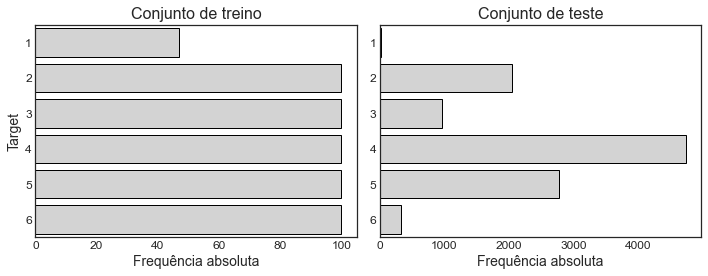

In [9]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# gráfico dos dados de treino
sns.countplot(y = 'TARGET', data = train, color = col, edgecolor = ec, ax = axes[0])
axes[0].set_title("Conjunto de treino", size = fs_title)
axes[0].set_xlabel("Frequência absoluta", size = 14)
axes[0].set_ylabel("Target", size = 14)

# gráfico dos dados de teste
sns.countplot(y = 'TARGET', data = test, color = col, edgecolor = ec, ax = axes[1])
axes[1].set_title("Conjunto de teste", size = fs_title)
axes[1].set_xlabel("Frequência absoluta", size = 14)
axes[1].set_ylabel("")

plt.tight_layout();

##### Visualização espacial dos dados de treino e teste

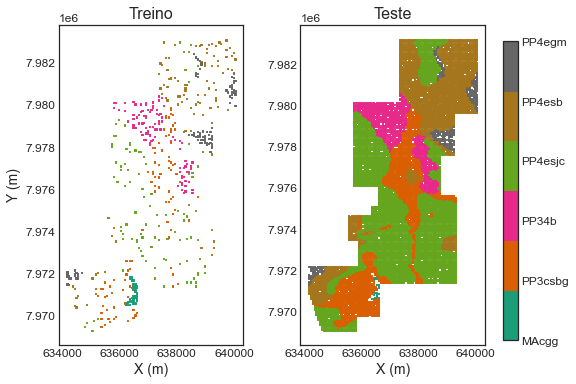

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 5.5))

# Localização dos dados de treino
p1 = ax1.scatter(data = train, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
ax1.set_title('Treino', size = fs_title)
ax1.set_xlabel('X (m)', size = 14)
ax1.set_ylabel('Y (m)', size = 14)

# Localização dos dados de teste
p2 = ax2.scatter(data = test, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
cbar = fig.colorbar(p2, ax = ax2, use_gridspec = False, anchor = (7, 0))
cbar.ax.set_yticklabels(['MAcgg','PP3csbg','PP34b','PP4esjc','PP4esb','PP4egm'])
ax2.set_title('Teste', size = fs_title)
ax2.set_xlabel('X (m)', size = 14)

plt.tight_layout();

### Escalonamento das features

In [11]:
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)

In [12]:
pd.DataFrame(X_train_std, columns = df[FEAT].columns).head()

,GT,K,TH,U,CT,U_K,TH_K,U_TH,MDT,B01,...,B03,B04,B05,B06,B07,B08,B09,R,G,B
0,1.925042,0.294877,-0.315957,0.403014,0.080342,-0.570957,-0.613666,0.396018,-1.647478,-0.883643,...,-0.850956,-1.029210,-0.176277,-1.145369,-1.322683,-0.841989,-1.003773,-0.236750,1.247100,0.781578
1,-0.697592,-0.635175,1.709698,0.444511,0.357349,0.317860,1.654651,-1.175458,1.617799,-0.824130,...,-0.769237,-0.242417,-1.150729,-0.209394,-0.339503,-0.387236,0.658618,-0.965742,-0.301601,0.001767
2,0.564241,-0.305536,-0.422973,-0.316259,-0.462130,-0.272755,-0.446748,0.275135,-0.916880,-0.297013,...,-0.188918,-0.149952,-0.358138,0.092082,-0.017206,-0.427049,-0.528804,-0.008940,0.417998,0.086529
3,-0.669770,-0.258445,-0.945312,-0.583681,-0.519840,-0.382771,-0.247575,0.275135,1.040786,0.796330,...,0.963430,0.825973,0.468382,1.079967,1.151339,1.176975,3.587592,-0.282312,-0.817835,-0.540711
4,0.026334,-0.529220,-0.774596,-0.431527,-0.773763,-0.269859,-0.387077,-0.027072,-2.231456,-0.589478,...,-0.489737,-0.468536,-0.174241,-0.208596,-0.240436,-0.809254,-2.349518,-0.540497,-1.662581,-0.676330


### Análise de Componentes Principais

A **Análise de Componentes Principais (PCA)** será realizada apenas nos sensores Landsat 8, com o intuito de redução da dimensionalidade.

In [13]:
pca = PCA(n_components = 9)
pcs = pca.fit_transform(X_train_std[:, np.arange(9,18)])

##### Variâncias relativas das componentes principais

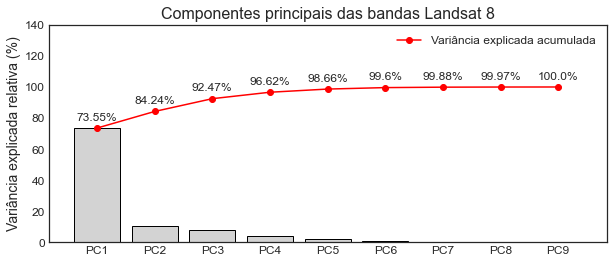

In [14]:
# variância explicada relativa de cada componente principal
explained_var = (pca.explained_variance_ratio_ * 100).round(2)
# variância explicada relativa acumulada
cum_explained_var = np.cumsum(explained_var).round(2)
# labels das componentes principais
pc_names = ['PC' + str(i) for i in range(1,10)]

# gráfico de barras de componentes principais
fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(111)
plt.bar(x = pc_names, height = explained_var, color = 'lightgray', edgecolor = ec)
plt.title("Componentes principais das bandas Landsat 8", size = fs_title)
plt.ylabel("Variância explicada relativa (%)", size = 14)

# gráfico de linha de variâncias acumuladas
ax2 = fig.add_subplot(111)
plt.plot(pc_names, cum_explained_var, color = 'red', marker = 'o', label = 'Variância explicada acumulada')
plt.yticks(np.arange(0,160,20))
plt.legend(loc = 'top right')

for i, v in enumerate(cum_explained_var):
    ax2.text(i, v + 5, str(v) + '%', ha = 'center', size = 12);

- Como as três primeiras componentes principais explicam ~92% da variância presente nas nove bandas Landsat 8, podemos reduzir as iniciais 9 features para apenas 3 componentes.

##### PCA personalizada

Agora que a PCA foi realizada nas bandas Landsat 8 e obteve-se um resultado satisfatório no que diz respeito à variância explicada pelas três primeiras componentes principais, a PCA personalizada (classe `MaskedPCA`) pode ser realizada. Essa classe permite que a PCA seja realizada apenas nas features Landsat 8, retornando as três componentes principais, além das demais features não envolvidas na redução de dimensionalidade.

Como as nove bandas Landsat 8 foram redimensionadas para três componentes principais, após a PCA, o número de features total reduzirá de 21 para 15.

In [15]:
# instanciação do objeto MaskedPCA
mask = np.arange(9,18)
masked_pca = MaskedPCA(n_components = 3, mask = mask)

# treinamento e transformação dos dados de treino
X_train_pca = masked_pca.fit_transform(X_train_std)
print(f'Dimensões das features de treino (pré-PCA) = {X_train_std.shape}')
print(f'Dimensões das features de treino (pós-PCA) = {X_train_pca.shape}\n')

Dimensões das features de treino (pré-PCA) = (547, 21)
Dimensões das features de treino (pós-PCA) = (547, 15)



##### Correlação entre features de treino após a PCA

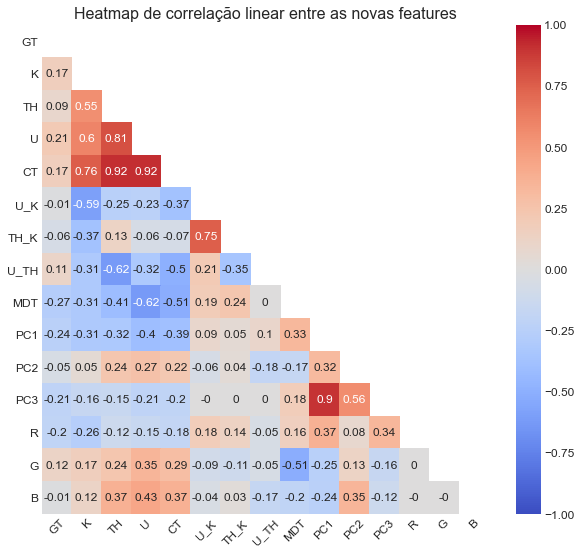

In [16]:
PCA_FEAT = ['GT','K','TH','U','CT','U_K','TH_K','U_TH','MDT','PC1','PC2','PC3','R','G','B']
df_X_train_pca = pd.DataFrame(X_train_pca, columns = PCA_FEAT)

# Matriz de correlação linear
pca_corr = df_X_train_pca.corr(method = 'pearson').round(2)

# heatmap
plt.figure(figsize = (10, 9))
plt.title ('Heatmap de correlação linear entre as novas features', size = fs_title)
mask = np.triu(np.ones_like(pca_corr, dtype = np.bool))
ax = sns.heatmap(
                 pca_corr, annot = True,
                 cmap = 'coolwarm', cbar = True,
                 mask = mask, vmin = -1.0, vmax = 1.0
                )
ax.set_xticklabels(PCA_FEAT, rotation = 45)
ax.set_yticklabels(PCA_FEAT, rotation = 0);

### Seleção de features

#### Seleção univariada - Teste F ANOVA

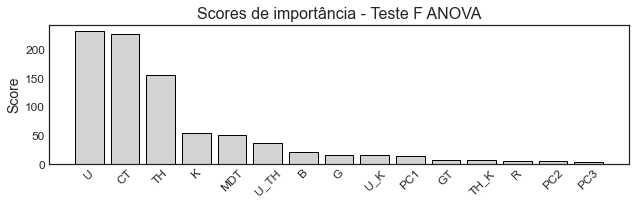

In [17]:
X_train_anova, anova_scores = univariateSelector(X_train_pca, y_train, f_classif)
plotSelectionScores(anova_scores, PCA_FEAT, method = 'Teste F ANOVA', col = col, ec = ec)

#### Seleção univariada - Informação Mútua

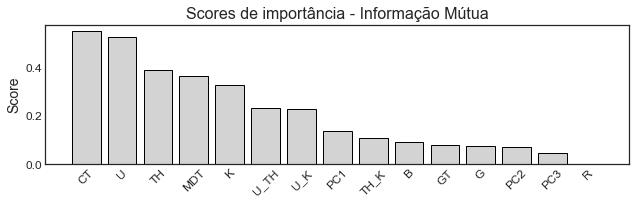

In [18]:
X_train_mut, mut_scores = univariateSelector(X_train_pca, y_train, mutual_info_classif)
plotSelectionScores(mut_scores, PCA_FEAT, method = 'Informação Mútua', col = col, ec = ec)

#### Seleção a partir do modelo - Random Forest

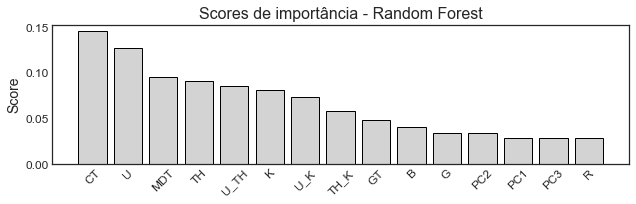

In [19]:
X_train_rf, rf_scores = randomForestSelector(X_train_pca, y_train, split = 'entropy')
plotSelectionScores(rf_scores, PCA_FEAT, method = 'Random Forest', col = col, ec = ec)

#### Exclusão de features com elevada correlação linear

De acordo com a matriz de correlação linear apresentada anteriormente, a feature `CT` apresenta uma forte correlação linear positiva com os três canais radiométricos e, portanto, será removida.

In [20]:
# Exclusão da feature CT
df.drop(['CT'], axis = 1, inplace = True)

# Atualização da lista de features após exclusão
FEAT = ['GT','K','TH','U','U_K','TH_K','U_TH','MDT','B01','B02','B03',
        'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'R', 'G', 'B']

### Superamostragem

#### SMOTE

In [21]:
X_train_smt, y_train_smt = SMOTE().fit_resample(X_train_rf, y_train)

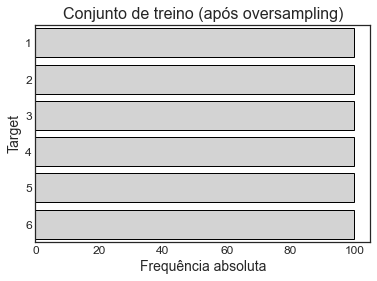

In [22]:
# transformação de narray em dataframe
train_smt = pd.DataFrame(X_train_smt, columns = PCA_FEAT)
train_smt['TARGET'] = y_train_smt

# gráfico de barras
sns.countplot(y = 'TARGET', data = train_smt, color = col, edgecolor = ec)

plt.title("Conjunto de treino (após oversampling)", size = fs_title)
plt.xlabel("Frequência absoluta", size = 14)
plt.ylabel("Target", size = 14);

<a id='4'></a>
## Modelagem dos dados

### Transformadores e variáveis

In [23]:
# número de exemplos de treino por unidade
nb_eg = 100

# método de escalonamento de features
scaler = StandardScaler()

# PCA personalizada
mask = np.arange(8,17)
dim_reduction = MaskedPCA(n_components = 3, mask = mask)

# número de features a serem selecionadas
nb_features = 10

# método de seleção de features
selector = SelectKBest(score_func = f_classif, k = nb_features)

# método de oversampling
oversamp = SMOTE(random_state = 42)

# número de folds da validação cruzada
n_folds = 5

# validação cruzada
cv = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)

# métrica de performance
metric = 'f1_weighted'

### Divisão entre treino e teste

In [24]:
X_train, y_train, X_test, y_test = customTrainTestSplit(df, FEAT, COORD,
                                                        samp_per_class = nb_eg,
                                                        threshold = 0.7)

print(f"Treino: X {X_train.shape}, y {y_train.shape}")
print(f"Teste: X {X_test.shape}, y {y_test.shape}")

Treino: X (547, 20), y (547,)
Teste: X (10871, 20), y (10871,)


### Criação de pipelines

Os pipelines abaixo são constituídos pelas seguintes etapas:

1. Escalonamento das features

2. Redução da dimensionalidade dos sensores Landsat 8

3. Seleção das features mais importantes

4. Superamostragem

5. Instanciação do classificador

In [25]:
# MLR
mlr_pipe = Pipeline(steps = [('scaler', scaler),
                             ('dim_reduction', dim_reduction),
                             ('selector', selector),
                             ('smote', oversamp),
                             ('clf', LogisticRegression(multi_class = 'multinomial', penalty = 'l2'))])

# DT
dt_pipe = Pipeline(steps = [('scaler', scaler),
                            ('dim_reduction', dim_reduction),
                            ('selector', selector),
                            ('smote', oversamp),
                            ('clf', DecisionTreeClassifier(random_state = 42))])

# GNB
gnb_pipe = Pipeline(steps = [('scaler', scaler),
                             ('dim_reduction', dim_reduction),
                             ('selector', selector),
                             ('smote', oversamp),
                             ('clf',GaussianNB(priors = [0.006,0.188,0.093,0.423,0.252,0.038]))])

# KNN
knn_pipe = Pipeline(steps = [('scaler', scaler),
                             ('dim_reduction', dim_reduction),
                             ('selector', selector),
                             ('smote', oversamp),
                             ('clf',KNeighborsClassifier())])

# SVM
svm_pipe = Pipeline(steps = [('scaler', scaler),
                             ('dim_reduction', dim_reduction),
                             ('selector', selector),
                             ('smote', oversamp),
                             ('clf', SVC(random_state = 42))])

# RF
rf_pipe = Pipeline(steps = [('scaler', scaler),
                            ('dim_reduction', dim_reduction),
                            ('selector', selector),
                            ('smote', oversamp),
                            ('clf', RandomForestClassifier(random_state = 42))])

# XGB
xgb_pipe = Pipeline(steps = [('scaler', scaler),
                             ('dim_reduction', dim_reduction),
                             ('selector', selector),
                             ('smote', oversamp),
                             ('clf', XGBClassifier(eval_metric = 'mlogloss', verbosity = 0, random_state = 42))])

# MLP
mlp_pipe = Pipeline(steps = [('scaler', scaler),
                             ('dim_reduction', dim_reduction),
                             ('selector', selector),
                             ('smote', oversamp),
                             ('clf', MLPClassifier(random_state = 42))])

In [26]:
pipe = {"MLR" : mlr_pipe,
        "DT"  : dt_pipe,
        "GNB" : gnb_pipe,
        "KNN" : knn_pipe,
        "SVM" : svm_pipe,
        "RF"  : rf_pipe,
        "XGB" : xgb_pipe,
        "MLP" : mlp_pipe}

### Treinamento dos classificadores

In [27]:
for p in pipe.keys():
    pipe[p].fit(X_train, y_train)

<a id='5'></a>
## Tuning dos modelos

##### Dicionário dos parâmetros de tuning

In [28]:
# MLR
mlr_param = [{'clf__solver'  : ['newton-cg','saga','sag','lbfgs'],
              'clf__C'       : np.logspace(-3,3,10)}]

# DT
dt_param = [{'clf__criterion'         : ['gini','entropy'],
             'clf__max_depth'         : [15,25,30,None],
             'clf__min_samples_split' : [1,2,5,10],
             'clf__min_samples_leaf'  : [1,2,5,10]}]

# GNB
gnb_param = [{'clf__var_smoothing' : np.logspace(-10,0,11)}]

# KNN
knn_param = [{'clf__n_neighbors'  : [i for i in range(3,30) if i % 2 != 0],
              'clf__weights'      : ['uniform', 'distance'],
              'clf__p'            : [1,2]}]

# SVM
svm_param = [{'clf__C'      : np.logspace(-3,3,10),
              'clf__gamma'  : [0.001, 0.01, 0.1, 1, 10, 100, 'auto'],
              'clf__kernel' : ['poly', 'rbf']}]

# RF
rf_param = [{'clf__n_estimators'      : [25,50,100,500],
             'clf__max_depth'         : [15,25,30,None],
             'clf__criterion'         : ['gini', 'entropy'],
             'clf__min_samples_split' : [1,2,5,10],
             'clf__min_samples_leaf'  : [1,2,5,10]}]

# XGB
xgb_param = [{'clf__eta'               : [0.01,0.015,0.025,0.05,0.1],
              'clf__learning_rate'     : [0.1,0.15,0.2,0.25,0.3,0.35,0.4],
              'clf__gamma'             : [0.05,0.1,0.3,0.4,0.5,0.7,0.9,1.0],
              'clf__max_depth'         : [3,5,7,9,12,15,17,25],
              'clf__min_child_weight'  : [1,3,5,7],
              'clf__subsample'         : [0.6,0.7,0.8,0.9,1.0],
              'clf__colsample_bytree'  : [0.6,0.7,0.8,0.9,1.0],
              'clf__reg_lambda'        : [10 ** i for i in range(-3,4)],
              'clf__alpha'             : [10 ** i for i in range(-3,4)]}]

# MLP
mlp_param = [{'clf__hidden_layer_sizes' : [(10,),(20,),(30,),(50,),(10,10),(20,20),(10,10,10),(10,30,10),(20,20,20)],
              'clf__activation'         : ['logistic','tanh','relu'],
              'clf__solver'             : ['lbfgs','sgd','adam'],
              'clf__alpha'              : [10 ** i for i in range(-3,4)],
              'clf__learning_rate'      : ['constant','adaptive'],
              'clf__learning_rate_init' : [0.0001,0.001,0.01,0.1,0.15,0.2,0.25,0.3],
              'clf__max_iter'           : [1,5,10,20,50,80,100,150,200,250]}]

param = [mlr_param, dt_param, gnb_param, knn_param, svm_param, rf_param, xgb_param, mlp_param]

In [29]:
# dicionários de hiperparâmetros por modelo
dic_param = {}
for k, p in zip(pipe.keys(), param):
    dic_param[k] = p

##### Tuning dos modelos

In [30]:
best_params = []

# para cada modelo, exceto RF e XGB
for m in ['MLR', 'DT', 'GNB', 'KNN', 'SVM']:
    # grid search
    grid = GridSearchCV(pipe[m], param_grid = dic_param[m], cv = cv, scoring = metric)
    grid.fit(X_train, y_train)
    best_params.append(grid.best_params_)
    print("----")
    print(m)
    print("Melhores parâmetros:", grid.best_params_)
    print('{0} = {1}'.format(metric, round(grid.best_score_, 3)))
    
# para apenas RF e XGB
for m in ['RF', 'XGB', 'MLP']:
    # random search
    random = RandomizedSearchCV(pipe[m], param_distributions = dic_param[m], cv = cv,
                                    scoring = metric, n_iter = 50, random_state = 42)
    random.fit(X_train, y_train)
    best_params.append(random.best_params_)
    print("----")
    print(m)
    print("Melhores parâmetros:", random.best_params_)
    print('{0} = {1}'.format(metric, round(random.best_score_, 3)))

----
MLR
Melhores parâmetros: {'clf__C': 0.46415888336127775, 'clf__solver': 'saga'}
f1_weighted = 0.576
----
DT
Melhores parâmetros: {'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}
f1_weighted = 0.608
----
GNB
Melhores parâmetros: {'clf__var_smoothing': 1e-10}
f1_weighted = 0.523
----
KNN
Melhores parâmetros: {'clf__n_neighbors': 7, 'clf__p': 1, 'clf__weights': 'distance'}
f1_weighted = 0.615
----
SVM
Melhores parâmetros: {'clf__C': 1000.0, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
f1_weighted = 0.626
----
RF
Melhores parâmetros: {'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_depth': 15, 'clf__criterion': 'gini'}
f1_weighted = 0.68
----
XGB
Melhores parâmetros: {'clf__subsample': 0.9, 'clf__reg_lambda': 0.001, 'clf__min_child_weight': 1, 'clf__max_depth': 12, 'clf__learning_rate': 0.15, 'clf__gamma': 0.9, 'clf__eta': 0.05, 'clf__colsample_bytree': 0.9, 'clf__alpha': 0.01}
f1_we

<a id='6'></a>
## Validação cruzada

##### Criação dos pipelines dos modelos otimizados

In [31]:
# baseline
dummy = Pipeline(steps = [('clf', DummyClassifier(strategy = "constant", constant = 4))])

# MLR
mlr = Pipeline(steps = [('scaler', scaler),
                        ('dim_reduction', dim_reduction),
                        ('selector', selector),
                        ('smote', oversamp),
                        ('clf', LogisticRegression(C = best_params[0]['clf__C'],
                                                   solver = best_params[0]['clf__solver'],
                                                   multi_class = 'multinomial',
                                                   penalty = 'l2'))])

# DT
dt = Pipeline(steps = [('scaler', scaler),
                       ('dim_reduction', dim_reduction),
                       ('selector', selector),
                       ('smote', oversamp),
                       ('clf', DecisionTreeClassifier(criterion = best_params[1]['clf__criterion'],
                                                      max_depth = best_params[1]['clf__max_depth'],
                                                      min_samples_split = best_params[1]['clf__min_samples_split'],
                                                      min_samples_leaf = best_params[1]['clf__min_samples_leaf'],
                                                      random_state = 42))])

# GNB
gnb = Pipeline(steps = [('scaler', scaler),
                        ('dim_reduction', dim_reduction),
                        ('selector', selector),
                        ('smote', oversamp),
                        ('clf', GaussianNB(var_smoothing = best_params[2]['clf__var_smoothing'],
                                           priors = [0.006,0.188,0.093,0.423,0.252,0.038]))])

# KNN
knn = Pipeline(steps = [('scaler', scaler),
                        ('dim_reduction', dim_reduction),
                        ('selector', selector),
                        ('smote', oversamp),
                        ('clf', KNeighborsClassifier(n_neighbors = best_params[3]['clf__n_neighbors'],
                                                     p = best_params[3]['clf__p'],
                                                     weights = best_params[3]['clf__weights']))])

# SVM
svm = Pipeline(steps = [('scaler', scaler),
                        ('dim_reduction', dim_reduction),
                        ('selector', selector),
                        ('smote', oversamp),
                        ('clf', SVC(C = best_params[4]['clf__C'],
                                    gamma = best_params[4]['clf__gamma'],
                                    kernel = best_params[4]['clf__kernel'],
                                    random_state = 42))])

# RF
rf = Pipeline(steps = [('scaler', scaler),
                       ('dim_reduction', dim_reduction),
                       ('selector', selector),
                       ('smote', oversamp),
                       ('clf', RandomForestClassifier(n_estimators = best_params[5]['clf__n_estimators'],
                                                      min_samples_split = best_params[5]['clf__min_samples_split'],
                                                      min_samples_leaf = best_params[5]['clf__min_samples_leaf'],
                                                      max_depth = best_params[5]['clf__max_depth'],
                                                      criterion = best_params[5]['clf__criterion'],
                                                      random_state = 42))])

# XGB
xgb = Pipeline(steps = [('scaler', scaler),
                        ('dim_reduction', dim_reduction),
                        ('selector', selector),
                        ('smote', oversamp),
                        ('clf', XGBClassifier(subsample = best_params[6]['clf__subsample'],
                                              reg_lambda = best_params[6]['clf__reg_lambda'],
                                              min_child_weight = best_params[6]['clf__min_child_weight'],
                                              max_depth = best_params[6]['clf__max_depth'],
                                              learning_rate = best_params[6]['clf__learning_rate'],
                                              gamma = best_params[6]['clf__gamma'], 
                                              eta = best_params[6]['clf__eta'],
                                              colsample_bytree = best_params[6]['clf__colsample_bytree'],
                                              alpha = best_params[6]['clf__alpha'],
                                              random_state = 42))])

# MLP
mlp = Pipeline(steps = [('scaler', scaler),
                        ('dim_reduction', dim_reduction),
                        ('selector', selector),
                        ('smote', oversamp),
                        ('clf', MLPClassifier(hidden_layer_sizes = best_params[7]['clf__hidden_layer_sizes'],
                                              activation = best_params[7]['clf__activation'],
                                              solver = best_params[7]['clf__solver'],
                                              alpha = best_params[7]['clf__alpha'],
                                              learning_rate = best_params[7]['clf__learning_rate'],
                                              learning_rate_init = best_params[7]['clf__learning_rate_init'], 
                                              max_iter = best_params[7]['clf__max_iter'],
                                              random_state = 42))])

tuned_models = {"DUMMY" : dummy,
                "MLR"   : mlr,
                "DT"    : dt,
                "GNB"   : gnb,
                "KNN"   : knn,
                "SVM"   : svm,
                "RF"    : rf,
                "XGB"   : xgb,
                "MLP"   : mlp}

##### Validação cruzada

In [ ]:
val_report = validationReport(tuned_models, X_train, y_train, cv)
val_report

##### Treinamento dos modelos otimizados

In [ ]:
for k in tuned_models.keys():
    tuned_models[k].fit(X_train, y_train)

<a id='7'></a>
## Predições

### Predições das unidades

In [ ]:
# baseline
ŷ_dummy = tuned_models['DUMMY'].predict(X_test)
# MLR
ŷ_mlr = tuned_models['MLR'].predict(X_test)
# DT
ŷ_dt = tuned_models['DT'].predict(X_test)
# GNB
ŷ_gnb = tuned_models['GNB'].predict(X_test)
# KNN
ŷ_knn = tuned_models['KNN'].predict(X_test)
# SVM
ŷ_svm = tuned_models['SVM'].predict(X_test)
# RF
ŷ_rf = tuned_models['RF'].predict(X_test)
# XGB
ŷ_xgb = tuned_models['XGB'].predict(X_test)
# MLP
ŷ_mlp = tuned_models['MLP'].predict(X_test)

dic_ŷ = {'DUMMY' : ŷ_dummy,
         'MLR'   : ŷ_mlr,
         'DT'    : ŷ_dt,
         'GNB'   : ŷ_gnb,
         'KNN'   : ŷ_knn,
         'SVM'   : ŷ_svm,
         'RF'    : ŷ_rf,
         'XGB'   : ŷ_xgb,
         'MLP'   : ŷ_mlp}

##### Visualização das predições

In [ ]:
# mapa preditivo
pred_map = createPredTable(dic_ŷ, train, test)
# mapa geológico
geo_map = pd.concat([train,test])
# mapa de inconsistências
miss_map = createMissClassifTable(pred_map, y_train, y_test)
# lista de modelos
models = ['MLR','DT','GNB','KNN','SVM','RF','XGB','MLP']

for model in models:
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
    
    # plotagem do mapa preditivo
    cm_map = ax1.scatter(data = pred_map, x = 'X', y = 'Y', c = model, cmap = cm, s = sz, marker = mk)
    ax1.set_title(model, size = fs_title)
    ax1.set_xlabel('X (m)', size = 14)
    ax1.set_ylabel('Y (m)', size = 14)
    
    # plotagem do mapa geológico
    ax2.scatter(data = geo_map, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
    ax2.set_title("Mapa geológico", size = fs_title)
    ax2.set_xlabel('X (m)', size = 14)
    
    # plotagem do mapa de inconsistências
    filtered_miss_map = miss_map[miss_map['MISS_' + model] == 1]
    ax3.scatter(data = filtered_miss_map, x = 'X', y = 'Y', c = 'red', s = 0.1, marker = 'o')
    ax3.set_title("Inconsistências", size = fs_title)
    ax3.set_xlabel('X (m)', size = 14)
    
    # legenda de unidades
    cbar = fig.colorbar(cm_map, ax = ax1, use_gridspec = False, anchor = (-27, 0))
    cbar.ax.set_yticklabels(['MAcgg','PP3csbg','PP34b','PP4esjc','PP4esb','PP4egm'])
    
    plt.tight_layout();

<a id='8'></a>
## Validação dos modelos

##### Matriz de confusão

In [ ]:
fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize = (10, 16))

for ax, m in zip(axs.flat, models):
    cm = confusion_matrix(y_test, dic_ŷ[m], normalize = 'true')
    p = ax.matshow(cm, cmap = 'coolwarm')
    fig.colorbar(p, ax = ax, boundaries = np.linspace(0.0,1.0,6))
    ax.set_title(str(m), size = fs_title, pad = 40)
    ax.set_xlabel('Predito', size = 14, labelpad = pad)
    ax.set_xticklabels([''] + labels, rotation = 45)
    ax.set_ylabel('Real', size = 14, labelpad = pad)
    ax.set_yticklabels([''] + labels)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.2f}'.format(z), ha = 'center', va = 'center')

plt.tight_layout();

##### Report de métricas de classificação

In [ ]:
for k in dic_ŷ.keys():
    print('---- \n')
    print(f'{k}:')
    print(classification_report(y_test, dic_ŷ[k]))

##### Métricas de validação do conjunto de teste

In [ ]:
test_report = testReport(dic_ŷ, y_test)
test_report

##### Comparação entre os resultados de validação e teste

In [ ]:
print("Report de validação:")
print(val_report)
print('\n----\n')
print("Report de teste:")
print(test_report)

In [ ]:
fig, ax = plt.subplots(3,1,figsize = (8, 10))

# heatmap de validação
sns.heatmap(val_report, cmap = 'coolwarm', annot = True, vmin = 0.5, vmax = 0.75, ax = ax[0])
ax[0].set_title('Validação', size = fs_title)

# heatmap de teste
sns.heatmap(test_report, cmap = 'coolwarm', annot = True, vmin = 0.4, vmax = 0.75, ax = ax[1])
ax[1].set_title('Teste', size = fs_title)

# heatmap da diferença entre validação e teste
sns.heatmap(val_report - test_report, cmap = 'coolwarm', annot = True, vmin = -0.1, vmax = 0.1, ax = ax[2])
ax[2].set_title('Diferença entre validação e teste', size = fs_title)

plt.tight_layout();

<a id='9'></a>
## Mapas de probabilidade por classes

#### Random Forest

In [ ]:
# predições probabilísticas (RF)
pr_rf = tuned_models['RF'].predict_proba(X_test)

# dataframe com as predições probabilísticas (RF)
df_pr_rf = createPredProbaTable(pr_rf, test)

In [ ]:
# mapas de probabilidade por classes (RF)
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 10))

for ax, label in zip(axs.flat, labels):
    rf_pr_map = ax.scatter(data = df_pr_rf, x = 'X', y = 'Y', c = label, cmap = 'Reds', s = sz, marker = mk)
    fig.colorbar(rf_pr_map, ax = ax, boundaries = np.linspace(0.0,1.0,6))
    ax.set_title(label, size = fs_title)
        
plt.tight_layout();

#### XGBoost

In [ ]:
# predições probabilísticas (XGB)
pr_xgb = tuned_models['XGB'].predict_proba(X_test)

# dataframe com as predições probabilísticas (XGB)
df_pr_xgb = createPredProbaTable(pr_xgb, test)

In [ ]:
# mapas de probabilidade por classes (XGB)
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 10))

for ax, label in zip(axs.flat, labels):
    xgb_pr_map = ax.scatter(data = df_pr_xgb, x = 'X', y = 'Y', c = label, cmap = 'Reds', s = sz, marker = mk)
    fig.colorbar(xgb_pr_map, ax = ax, boundaries = np.linspace(0.0,1.0,6))
    ax.set_title(label, size = fs_title)
        
plt.tight_layout();

<a id='10'></a>
## Mapas de entropia cruzada

In [ ]:
# cálculo da entropia para o modelo RF
H_rf = categoricalCrossEntropy(pr_rf, dic_ŷ['RF'], test)

# cálculo da entropia para o modelo RF
H_xgb = categoricalCrossEntropy(pr_xgb, dic_ŷ['XGB'], test)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (9.5, 7))

# mapa de entropia cruzada - RF
rf_H_map = ax1.scatter(data = H_rf, x = 'X', y = 'Y', c = 'ENTROPY', cmap = 'Reds', s = sz, marker = mk)
ax1.set_title('Entropia Cruzada - RF', size = fs_title)
ax1.set_xlabel('X (m)', size = 14)
ax1.set_ylabel('Y (m)', size = 14)
fig.colorbar(rf_H_map, ax = ax1, boundaries = np.linspace(0.0,2.5,6))

# mapa de entropia cruzada - XGB
xgb_H_map = ax2.scatter(data = H_xgb, x = 'X', y = 'Y', c = 'ENTROPY', cmap = 'Reds', s = sz, marker = mk)
ax2.set_title('Entropia Cruzada - XGB', size = fs_title)
ax2.set_xlabel('X (m)', size = 14)
fig.colorbar(xgb_H_map, ax = ax2, boundaries = np.linspace(0.0,2.5,6))

plt.tight_layout();

<a id='11'></a>
## Exportação dos resultados

In [ ]:
if save_results:
    # predições realizadas por cada modelo
    pred_map.to_csv('output/out_pred.csv', header = True, index = False, float_format='%.3f')

    # predições probabilísticas (RF)
    df_pr_rf.to_csv('output/out_pred_proba_rf.csv', header = True, index = False, float_format='%.3f')
    
    # predições probabilísticas (XGB)
    df_pr_xgb.to_csv('output/out_pred_proba_xgb.csv', header = True, index = False, float_format='%.3f')
    
    # inconsistências apresentadas por cada modelo
    miss_map.to_csv('output/out_missclassif.csv', header = True, index = False, float_format='%.3f')
    
    # entropia cruzada (RF)
    H_rf.to_csv('output/out_entropy_rf.csv', header = True, index = False, float_format='%.3f')
    
    # entropia cruzada (XGB)
    H_xgb.to_csv('output/out_entropy_xgb.csv', header = True, index = False, float_format='%.3f')